In [8]:
from typing import Literal
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import cvxpy as cp
import numpy as np

In [9]:
tickers = [
    # U.S. Large-Cap Equities
    "MSFT",   # Microsoft Corp
    "AAPL",   # Apple Inc
    "JNJ",    # Johnson & Johnson
    "WMT",    # Walmart Inc
    "V",      # Visa Inc

    # International Large-Cap Equities
    "ASML",   # ASML Holding NV
    "TSM",    # Taiwan Semiconductor Manufacturing Co Ltd
    "NVO",    # Novo Nordisk A/S

    # Some Hand Picked Items
    "ASRNL.AS",
    "PEP",

    # Broad-Market Equity & Multi-Asset ETFs
    "VTI",    # Vanguard Total Stock Market ETF
    "VXUS",   # Vanguard Total International Stock ETF
    "ACWI",   # iShares MSCI ACWI ETF (All-Country World)
    "AGG",    # iShares Core U.S. Aggregate Bond ETF

    # Global Fixed Income
    "BNDX",   # Vanguard Total International Bond ETF
    "TIP",    # iShares TIPS Bond ETF (Inflation-Protected)

    # Real Estate
    "VNQ",    # Vanguard Real Estate ETF

    # Precious Metals & Commodities
    "GLD",    # SPDR Gold Shares
    "SLV",    # iShares Silver Trust
    "DBC",    # Invesco DB Commodity Index Tracking Fund

    # Cryptocurrencies
    "BTC-EUR",  # Bitcoin / EUR
    "ETH-EUR"   # Ethereum / EUR
]


**Load data from yahoo finance**

In [10]:
# Load data and preprocess data into a proper structure. 
ohlc = yf.download(tickers, period="max")
prices = ohlc["Close"].dropna(how="all")
prices.tail()

[*********************100%***********************]  22 of 22 completed


Ticker,AAPL,ACWI,AGG,ASML,ASRNL.AS,BNDX,BTC-EUR,DBC,ETH-EUR,GLD,...,NVO,PEP,SLV,TIP,TSM,V,VNQ,VTI,VXUS,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-29,199.949997,123.910004,97.860001,747.070007,56.200001,49.380001,95999.046875,21.040001,2388.537354,305.609985,...,69.459999,131.919998,30.299999,108.930000,197.149994,362.399994,89.320000,290.119995,67.110001,97.099998
2025-05-30,200.850006,123.650002,98.099998,736.770020,56.480000,49.450001,92856.468750,20.879999,2314.037842,303.600006,...,71.500000,131.449997,30.000000,109.290001,193.320007,365.190002,89.320000,289.880005,66.940002,98.720001
2025-05-31,NaN,NaN,NaN,NaN,NaN,NaN,91647.703125,NaN,2229.487549,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-01,NaN,NaN,NaN,NaN,NaN,NaN,92211.273438,NaN,2228.732910,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-02,NaN,124.434998,97.403000,746.015015,56.779999,49.285000,91370.281250,21.299299,2227.881348,311.369995,...,72.599998,130.669998,NaN,108.550003,195.009995,364.480011,89.264999,291.109985,67.522202,99.495003


**Handle Missing Data**

In [11]:
cleaned = prices.interpolate(method='linear', axis=0)
cleaned.tail()

Ticker,AAPL,ACWI,AGG,ASML,ASRNL.AS,BNDX,BTC-EUR,DBC,ETH-EUR,GLD,...,NVO,PEP,SLV,TIP,TSM,V,VNQ,VTI,VXUS,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-29,199.949997,123.910004,97.860001,747.070007,56.200001,49.380001,95999.046875,21.040001,2388.537354,305.609985,...,69.459999,131.919998,30.299999,108.930000,197.149994,362.399994,89.320000,290.119995,67.110001,97.099998
2025-05-30,200.850006,123.650002,98.099998,736.770020,56.480000,49.450001,92856.468750,20.879999,2314.037842,303.600006,...,71.500000,131.449997,30.000000,109.290001,193.320007,365.190002,89.320000,289.880005,66.940002,98.720001
2025-05-31,200.850006,123.911667,97.867666,739.851685,56.579999,49.395000,91647.703125,21.019766,2229.487549,306.190002,...,71.866666,131.189997,30.000000,109.043335,193.883336,364.953339,89.301666,290.289998,67.134069,98.978335
2025-06-01,200.850006,124.173332,97.635333,742.933350,56.679999,49.340000,92211.273438,21.159533,2228.732910,308.779999,...,72.233332,130.929998,30.000000,108.796669,194.446665,364.716675,89.283333,290.699992,67.328135,99.236669
2025-06-02,200.850006,124.434998,97.403000,746.015015,56.779999,49.285000,91370.281250,21.299299,2227.881348,311.369995,...,72.599998,130.669998,30.000000,108.550003,195.009995,364.480011,89.264999,291.109985,67.522202,99.495003


**Store the cleaned dataset for later post-hoc use**

In [12]:
cleaned.to_csv("../../data/cleaned_prices", sep=",", index=True)

<Axes: xlabel='Date'>

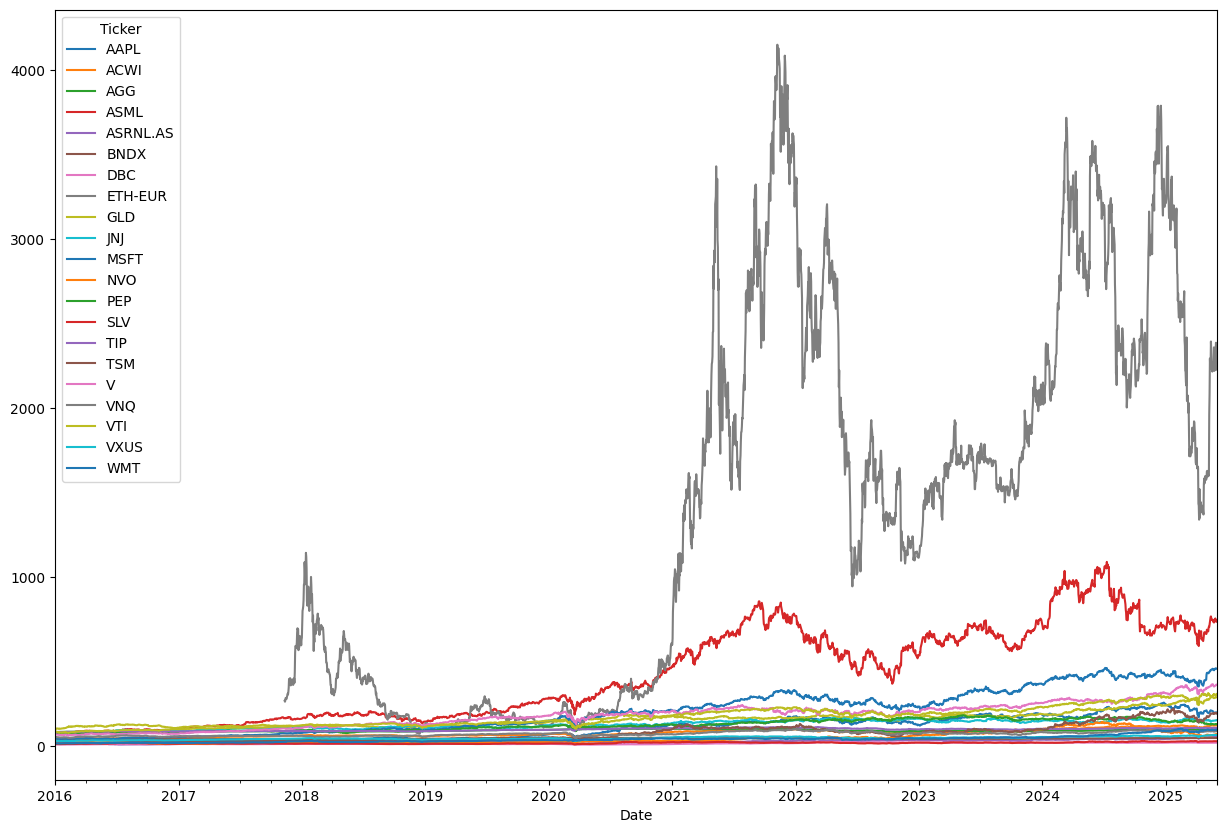

In [13]:
filtered = cleaned.drop(columns=["BTC-EUR"]) # excluded BTC since it performed so well over this period that the other assets were not visable on the chart
filtered[filtered.index >= "2016-01-01"].plot(figsize=(15, 10))

# Estimation Models

In [14]:
from math import log2, asin, sqrt
from typing import List, Tuple

import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

class QuantumAmplitudeEstimator:
    """
    Measurement‐based amplitude estimation for mean & variance (Qiskit v2.0+),
    using a uniform superposition over indices (not weights ∝ x_i). Estimates the
    arithmetic mean and variance of a nonnegative dataset.

    - window_size: must be a power of 2 (the number of data points).
    - shots: number of measurement shots per amplitude estimate.

    predict(data) → (mean_est, variance_est).
    """

    def __init__(self, window_size: int, shots: int = 10_000) -> None:
        # window_size must be a power of 2
        if window_size & (window_size - 1) != 0:
            raise ValueError("window_size must be a power of 2.")
        self.window_size = window_size
        self.n_index_qubits = int(log2(window_size))
        self.shots = shots

        # Use AerSimulator (we only need to measure ancilla & index)
        self.backend = AerSimulator()

    def _build_A_circuit(self, values: List[float], encode_power: int) -> QuantumCircuit:
        """
        Build the “A” operator on (n_index_qubits + 1) qubits:

          |0^n> |0>  →  (1/√N) ∑_i |i> [cos(theta_i)|0> + sin(theta_i)|1>]

        where:
          - encode_power=1: θ_i = arcsin(sqrt(x_i / X_max))
              → sin^2(θ_i) = x_i / X_max = f(i)
              => ancilla “1” probability = (1/N) ∑_i x_i/X_max = E[X]/X_max.
          - encode_power=2: θ_i = arcsin(x_i / X_max)
              → sin^2(θ_i) = x_i^2 / X_max^2 = g(i)
              => ancilla “1” probability = (1/N) ∑_i x_i^2/X_max^2 = E[X^2]/X_max^2.

        values: length = window_size, all ≥ 0.
        encode_power: 1 (for mean pass) or 2 (for second moment pass).
        """
        N = self.window_size
        n = self.n_index_qubits

        X_max = max(values)
        if X_max <= 0:
            raise ValueError("All data values are zero; cannot normalize nonzero range.")

        # Build circuit on n index qubits + 1 ancilla + n+1 classical bits
        qc = QuantumCircuit(n + 1, n + 1)

        # 1) Prepare uniform superposition on index qubits
        qc.h(range(n))

        # 2) For each basis index |i>, rotate ancilla by 2θ_i, controlled on |i>
        ancilla = n
        for i in range(N):
            x_i = values[i]
            if encode_power == 1:
                # want sin(θ_i) = sqrt(x_i / X_max)
                sin_theta = sqrt(x_i / X_max)
            else:  # encode_power == 2
                # want sin(θ_i) = x_i / X_max
                sin_theta = x_i / X_max

            # Clamp to [0,1]
            sin_theta = max(0.0, min(1.0, sin_theta))
            theta = asin(sin_theta)
            angle = 2.0 * float(theta)

            # Build binary string for index i (length n)
            bitstr = format(i, f"0{n}b")

            # 2a) Flip index qubits that are '0' to '1' for mcry control
            for q_idx, bit in enumerate(bitstr):
                if bit == "0":
                    qc.x(q_idx)

            # 2b) Apply multi‐controlled Ry(angle) with all n index qubits controlling ancilla
            qc.mcry(angle, list(range(n)), ancilla, None, mode="noancilla")

            # 2c) Undo the X flips on index qubits
            for q_idx, bit in enumerate(bitstr):
                if bit == "0":
                    qc.x(q_idx)

        # 3) Measure ancilla in cbit 0, and index qubits in next n cbits
        qc.measure(range(n + 1), range(n + 1))
        return qc

    def _estimate_amplitude(self, values: List[float], encode_power: int) -> float:
        """
        Build A with given encode_power, run 'shots' times, measure ancilla repeatedly.
        Return empirical frequency of ancilla=1, which approximates:
          - encode_power=1: E[X] / X_max
          - encode_power=2: E[X^2] / X_max^2
        """
        qc = self._build_A_circuit(values, encode_power=encode_power)
        t_qc = transpile(qc, self.backend)
        job = self.backend.run(t_qc, shots=self.shots)
        result = job.result()
        counts = result.get_counts()

        # Each key is a bitstring of length (n_index_qubits+1),
        # with bit 0 = ancilla measurement (MSB of string returned by get_counts).
        total_counts = sum(counts.values())
        ancilla_one_counts = 0
        for bitstr, cnt in counts.items():
            # bitstr[0] is the ancilla bit (since measure() stored ancilla as cbit 0)
            if bitstr[0] == "1":
                ancilla_one_counts += cnt

        return ancilla_one_counts / total_counts

    def predict(self, data: List[float]) -> Tuple[float, float]:
        """
        Estimate (mean, variance) for nonnegative `data` list of length = window_size.

        Returns: (mean_estimate, variance_estimate).
        """
        if len(data) != self.window_size:
            raise ValueError(f"Expected {self.window_size} data points, got {len(data)}.")
        if any(x < 0 for x in data):
            raise ValueError("All data values must be nonnegative.")

        X_max = max(data)
        if X_max <= 0:
            # All data zeros → mean = var = 0
            return 0.0, 0.0

        # Pass 1: estimate a1 ≈ E[X] / X_max
        a1 = self._estimate_amplitude(data, encode_power=1)
        E_X = a1 * X_max

        # Pass 2: estimate a2 ≈ E[X^2] / X_max^2
        a2 = self._estimate_amplitude(data, encode_power=2)
        E_X2 = a2 * (X_max**2)

        var_X = E_X2 - (E_X**2)
        return E_X, var_X

In [15]:
class MonteCarloEstimator:
    def __init__(self, window_size: int,) -> None:
        self.window_size = window_size

    def predict(self, data: list[float]) -> tuple[float, float]:
        if len(data) != self.window_size:
            raise ValueError(
                f"Expected {self.window_size} data points, got {len(data)}."
            )
        n = self.window_size

        mean_est = sum(data) / n
        var_est = sum((x - mean_est) ** 2 for x in data) / n

        return mean_est, var_est


# Estimation Pipeline for the Expected Return and Variance Variables

In [16]:
# Model the pipeline somehow

class Pipeline:
    def __init__(self, data: pd.DataFrame, window_size: int, EstimationModel: Literal["Monte-Carlo", "QAE"]) -> None:
        self.sampler_name = EstimationModel
        self.data = data
        self.L = window_size

        if EstimationModel == "QAE":
            pass
            self.sampler = QuantumAmplitudeEstimator(window_size, shots=20_000)
        elif EstimationModel == "Monte-Carlo":
            self.sampler = MonteCarloEstimator(window_size)
        else:
            raise ValueError(f"Unknown EstimationModel: {EstimationModel}")
    
    def run(self, window_start: str, window_end: str) -> pd.DataFrame:
        start_ts = pd.to_datetime(window_start)
        end_ts = pd.to_datetime(window_end)
        df_window = self.data.loc[start_ts : end_ts]

        records = []
        window_label = f"{window_start}:{window_end}"

        for stock in df_window.columns:
            timeSeries: list[float] = df_window[stock].tolist()
            if len(timeSeries) == self.L:
                xmean, variance = self.sampler.predict(timeSeries)
                records.append({
                    "window":    window_label,
                    "stock":     stock,
                    "Xmean":     xmean,
                    "Variance":  variance,
                    "Estimator": self.sampler_name
                })
            else:
                # Skip stocks without exactly L non‐missing observations
                continue

        if records:
            result_df = pd.DataFrame.from_records(
                records, 
                columns=["window", "stock", "Xmean", "Variance", "Estimator"]
            )
        else:
            result_df = pd.DataFrame([], columns=["window", "stock", "Xmean", "Variance", "Estimator"])
        return result_df

    def model(self, start: str, end: str) -> pd.DataFrame:
        start_ts = pd.to_datetime(start)
        end_ts = pd.to_datetime(end)

        # Extract all trading dates in the data between start and end (inclusive), sorted
        all_dates = self.data.index
        mask = (all_dates >= start_ts) & (all_dates <= end_ts)
        window_dates = sorted(all_dates[mask])

        # If there are fewer than L total dates in [start, end], no windows can be formed
        if len(window_dates) < self.L:
            raise RuntimeError("Data did not match window size")
            return pd.DataFrame([], columns=["window", "stock", "Xmean", "Variance", "Estimator"])

        # Slide a length-L block over window_dates, moving one index at a time
        results = []
        total_windows = len(window_dates) - self.L + 1

        for i in tqdm(range(total_windows), desc="Estimating..."):
            win_start = window_dates[i]
            win_end   = window_dates[i + self.L - 1]

            # Format back to "YYYY-MM-DD" strings to pass into run()
            win_start_str = win_start.strftime("%Y-%m-%d")
            win_end_str   = win_end.strftime("%Y-%m-%d")

            df_win = self.run(win_start_str, win_end_str)
            results.append(df_win)

        return pd.concat(results, axis=0, ignore_index=True)

timestamp | stock 
    1     |  100
    2     |  101
    3     |  102

In [17]:
# configuration
window_size: int = 64 # in days (little over two months and 2^6 thus QAE compat)

pipeline_classical = Pipeline(cleaned, window_size, "Monte-Carlo")
pipeline_quantum = Pipeline(cleaned, window_size, EstimationModel="QAE")

In [18]:
classical_estimation_data = pipeline_classical.model(start="2019-01-01", end="2025-05-30")
classical_estimation_data.to_csv(f"../../data/classicial_estimations_L{window_size}", sep=",", index=False)

Estimating...: 100%|██████████| 2279/2279 [00:01<00:00, 1470.51it/s]


**Store the data we gathered, because running on Quantum hardware is expensive**

In [19]:
quantum_estimation_data = pipeline_quantum.model(start="2025-01-01", end="2025-05-30")
quantum_estimation_data.to_csv(f"../../data/quantum_estimations_L{window_size}", sep=",", index=False)

Estimating...: 100%|██████████| 87/87 [33:00<00:00, 22.77s/it]


### Some basic visualisations of what we've gathered

In [20]:
def mean_variance_plot(df: pd.DataFrame, ticker: str) -> None:
    df_stock = df[df["stock"] == ticker].copy()
    df_stock = df_stock.dropna(subset=["Xmean", "Variance"])

    df_stock["window_end"] = pd.to_datetime(
        df_stock["window"].str.split(":", n=1).str[1]
    )

    df_stock = df_stock.sort_values("window_end")
    df_stock = df_stock.set_index("window_end")

    fig, (ax_mean, ax_var) = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(14, 5),
        sharex=True
    )
    ax_mean.plot(
        df_stock.index,
        df_stock["Xmean"],
        linestyle="-",
        label="Mean"
    )
    ax_mean.set_title(f"{ticker} – Mean over Time")
    ax_mean.set_xlabel("Window End Date")
    ax_mean.set_ylabel("Mean")
    ax_mean.grid(True)

    ax_var.plot(
        df_stock.index,
        df_stock["Variance"],
        linestyle="-",
        color="tab:orange",
        label="Variance"
    )
    ax_var.set_title(f"{ticker} – Variance over Time")
    ax_var.set_xlabel("Window End Date")
    ax_var.set_ylabel("Variance")
    ax_var.grid(True)

    for ax in (ax_mean, ax_var):
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    plt.tight_layout()
    plt.show()

In [21]:
def mean_variance_single_plot(df: pd.DataFrame, ticker: str) -> None:
    df_stock = df[df["stock"] == ticker].copy()
    df_stock = df_stock.dropna(subset=["Xmean", "Variance"])

    df_stock["window_end"] = pd.to_datetime(
        df_stock["window"].str.split(":", n=1).str[1]
    )
    df_stock = df_stock.sort_values("window_end").set_index("window_end")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(
        df_stock.index,
        df_stock["Xmean"],
        color="tab:blue",
        linestyle="-",
        label="Xmean"
    )
    ax1.set_xlabel("Window End Date")
    ax1.set_ylabel("Mean", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.plot(
        df_stock.index,
        df_stock["Variance"],
        color="tab:orange",
        linestyle="-",
        label="Variance"
    )
    ax2.set_ylabel("Variance", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    plt.title(f"{ticker} – Mean (left) and Variance (right) over Time")

    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")

    plt.tight_layout()
    plt.show()

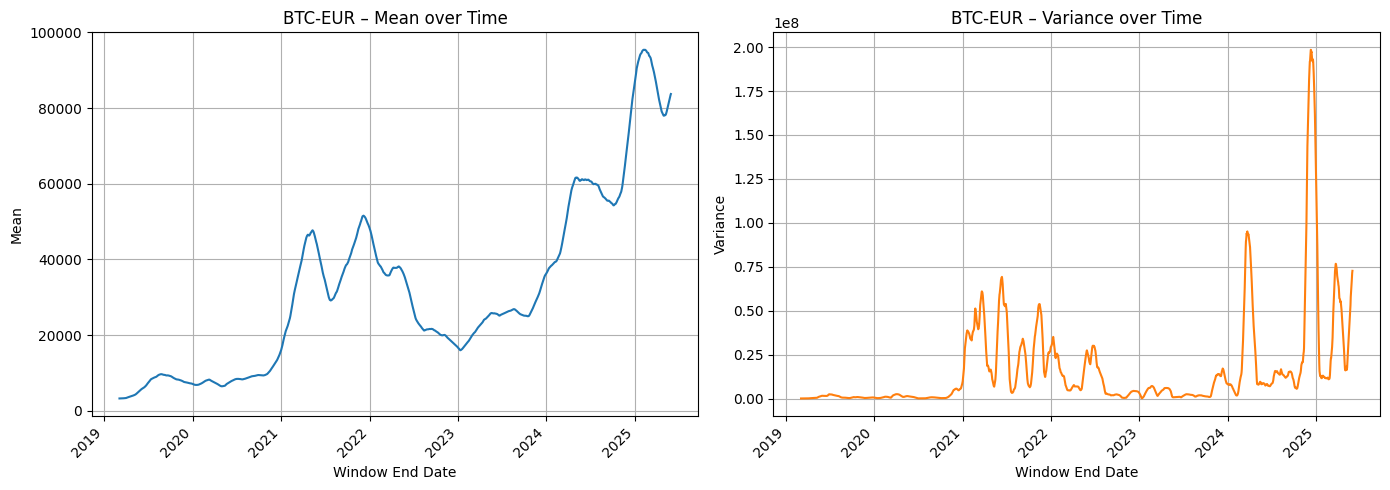

In [22]:
mean_variance_plot(classical_estimation_data, "BTC-EUR")

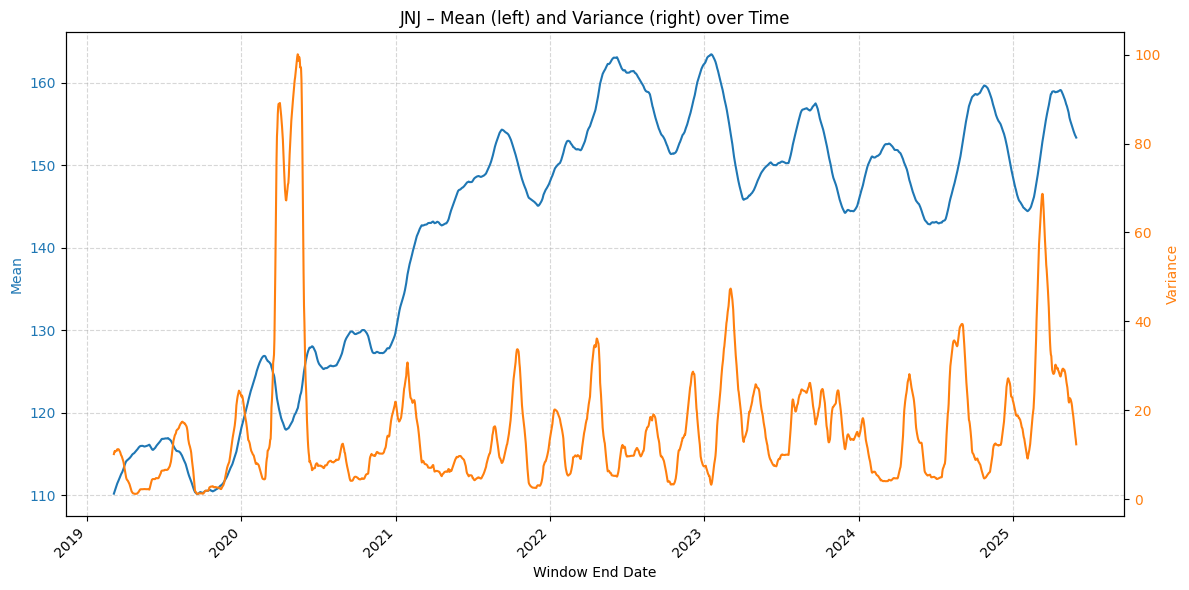

In [23]:
mean_variance_single_plot(classical_estimation_data, "JNJ")

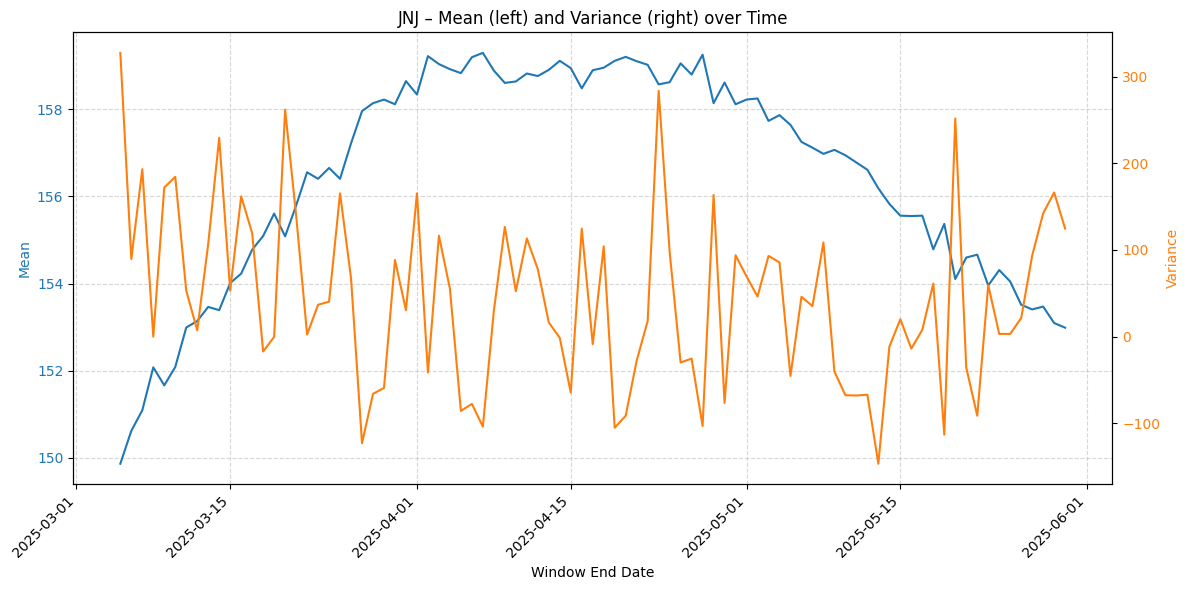

In [24]:
mean_variance_single_plot(quantum_estimation_data, "JNJ")